# Quanvolutional Neural Networks

In [2]:
import pennylane as qml
# Just like standard NumPy, but with the added benefit of automatic differentiation
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

In this notebook we implement the *Quanvolutional Neural Network*, a quantum machine learning model originally introduced in [Henderson et al. (2019)](https://arxiv.org/abs/1904.04767).

<img src="circuit.png" alt="circuit" width="600"/>

## Introduction

A *Convolutional Neural Network* (**CNN**) is a standard model in (classical) machine learning, especially suitable for image processing. This model is based on the idea of a *convolution layer* where, instead of processing the full input data with a global function, a *local* convolution is applied.
Small local regions are sequentially processed with the same kernel. The results obtained for each region are then associated to different channels of a single output pixel. The union of all the output pixels produces a new image-like object, which can be further processed by additional layers.

One can then consider **quantum variational circuits**, which are quantum algorithms depending on free parameters. These algorithms are trained by a **classical optimization** algorithm that makes queries to the **quantum device**, the optimization being an iterative scheme that searches out better candidates for the parameters with every step. Variational circuits have become popular as a way to think about quantum algorithms for **near-term quantum devices**.

In this notebook we will implement a simplified approach, which will, however, allow us to grasp the idea behind the so-called Quanvolutional Neural Networks (**QNNs**). The scheme is represented in the figure at the top.

1.  A small region of the input image, in our example a $2 \times 2$ square, is embedded into a quantum circuit – this is achieved with parametrized rotations applied to the qubits initialized in the ground state.
2.  A quantum computation, associated to a unitary $U$, is performed on the system – the unitary could be generated by a variational quantum circuit or, more simply, by a *random circuit* as proposed in [Henderson et al. (2019)](https://arxiv.org/abs/1904.04767).
3.  The quantum system is measured, obtaining a list of classical expectation values.
4.  Analogously to a classical convolution layer, each expectation value is mapped to a different channel of a single output pixel.
5.  Iterating the same procedure over different regions, one can scan the full input image, producing an output object which will be structured as a multi-channel image.

**Note** that:
- a fixed non-trainable quantum circuit is used as a "quanvolution" kernel, while the subsequent classical layers are trained for the classification problem of interest;
- the quanvolution can be followed by further quantum layers or by classical layers;
- the **main difference** with respect to a classical convolution is that a quantum circuit can generate highly-complex kernels whose computation could be – at least in principle – classically intractable.

## Setting of hyper-parameters

In [59]:
n_epochs = 50
n_layers = 1
n_train = 150
n_test = 50

SAVE_PATH = "./quanvolution/"
PREPROCESS = True           # False --> skip quantum processing and load data from SAVE_PATH
np.random.seed(0)
tf.random.set_seed(0)

## MNIST dataset

Here we will use only a small number of training and test images to speedup the evaluation; obviously, better results are achievable using the full dataset.

In [60]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension (for convolution channels)
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

## Quantum circuit as a convolution kernel

Now we initialize a [PennyLane](https://pennylane.ai/) `default.qubit` device – a pure-state qubit simulator – simulating a system of $4$ qubits. The associated `qnode` – an abstract encapsulation of a quantum function, described by a quantum circuit – consists of:

1.  an embedding layer of local $R_y$ rotations (with angles scaled by a factor of $\pi$);
2.  a random circuit of `n_layers`;
3.  a final measurement in the computational basis, estimating $4$ expectation values.

In [61]:
dev = qml.device("default.qubit", wires=4)

# Random circuit parameters
rand_params = np.random.uniform(high=2*np.pi, size=(n_layers, 4))

# Generate some random classical data
data = np.random.uniform(low=-np.pi, high=np.pi, size=(4,))

# To convert the function into a QNode running on dev, we apply the qnode() decorator
@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi*phi[j], wires=j)
        # qml.Hadamard(wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement (expect. val.) producing 4 classical outputs
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

We now build a function defining the convolution scheme:

1.  the image is divided into squares of $2 \times 2$ pixels;
2.  each square is processed by the quantum circuit;
3.  the $4$ expectation values are mapped into $4$ different channels of a single output pixel.

The process *halves* the resolution of the input image. In the standard CNN-language, this would correspond to a convolution with a $2 \times 2$ *kernel* and a *stride* equal to $2$.

In [62]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit"""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a 2x2 region with the quantum circuit
            q_results = circuit(
                [image[j, k, 0], image[j, k + 1, 0],
                 image[j + 1, k, 0], image[j + 1, k + 1, 0]]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

## Quantum pre-processing

Since we are not going to train the quantum convolution layer, we apply it as a **pre-processing** layer to the images; then, an entirely "classical" model will be trained and tested on the pre-processed dataset. This procedure will let us avoid unnecessary repetitions of quantum computations.

The pre-processed images are saved in the folder `SAVE_PATH`, thus they can be directly loaded by setting `PREPROCESS = False` – otherwise the quantum convolution is evaluated at each run of the code.

In [63]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print(f"{idx + 1}/{n_train}        ", end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print(f"{idx + 1}/{n_test}        ", end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
150/150        
Quantum pre-processing of test images:


Let us visualize the effect of the quantum convolution layer on a batch
of samples:


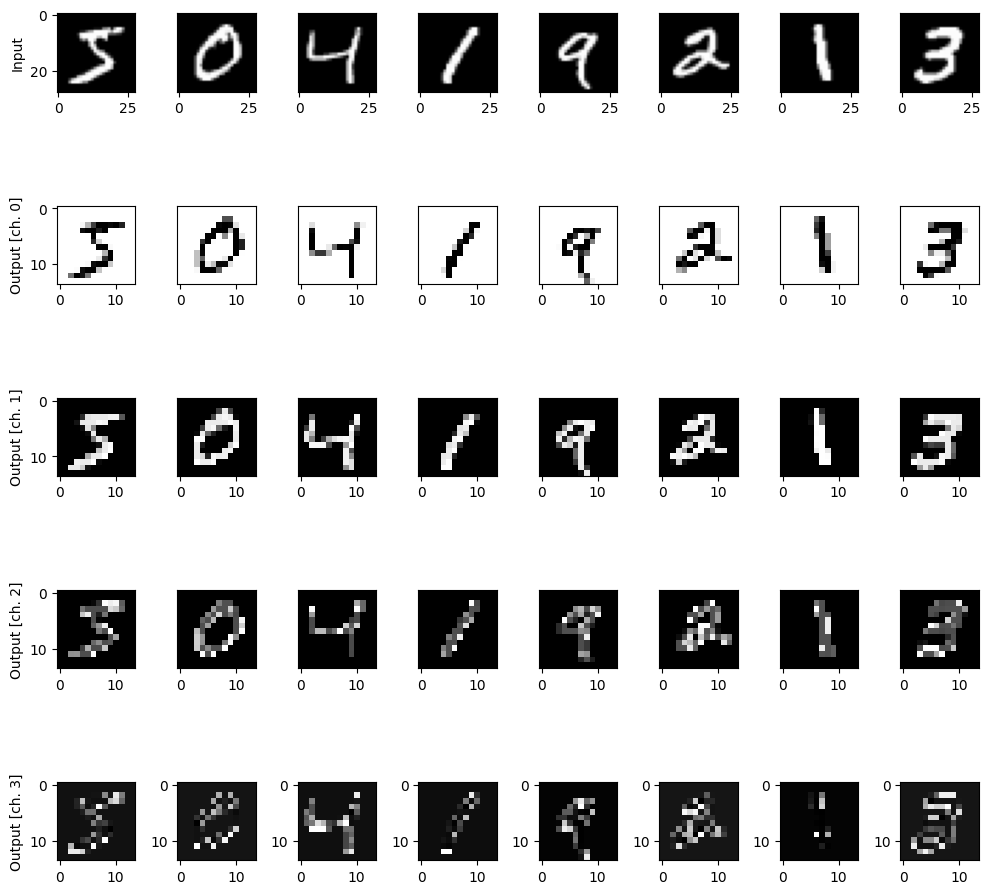

In [64]:
n_samples = 8
n_channels = 4

fig, axes = plt.subplots(1+n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel(f"Output [ch. {c}]")
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.savefig(f'out_q_layer_{n_samples}_samples.png', dpi=300, facecolor='w')
plt.show()

Below each input image, the $4$ output channels generated by the quantum convolution are visualised.

One can clearly notice the **downsampling** of the resolution, along with some local distortion introduced by the quantum kernel; on the other hand, the global shape of the image is preserved, as expected for a convolution layer.

## Hybrid quantum-classical model

After the quanvolution layer, we feed the resulting features into a classical neural network that will be trained to classify the $10$ different digits of the dataset.

We use a *very* simple model: just a **fully connected layer with 10 output nodes** with a final *softmax* activation function.
The model is compiled with a robust and effective *stochastic-gradient-descent* optimizer, **Adam**, and a *cross-entropy* loss function.

In [65]:
def model():
    """Initializes and returns a Keras model to be trained"""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

## Training

We first instantiate the model, then we train and validate it on the dataset that has been *already pre-processed* by the quanvolution.

In [66]:
q_model = model()

q_history = q_model.fit(q_train_images, train_labels,
                        validation_data=(q_test_images, test_labels),
                        batch_size=4, epochs=n_epochs, verbose=2)

Epoch 1/50
38/38 - 1s - 15ms/step - accuracy: 0.2467 - loss: 2.3335 - val_accuracy: 0.3800 - val_loss: 1.8987
Epoch 2/50
38/38 - 0s - 2ms/step - accuracy: 0.5400 - loss: 1.4977 - val_accuracy: 0.4800 - val_loss: 1.5306
Epoch 3/50
38/38 - 0s - 2ms/step - accuracy: 0.7800 - loss: 1.0525 - val_accuracy: 0.5600 - val_loss: 1.3167
Epoch 4/50
38/38 - 0s - 2ms/step - accuracy: 0.8467 - loss: 0.7907 - val_accuracy: 0.6200 - val_loss: 1.1846
Epoch 5/50
38/38 - 0s - 2ms/step - accuracy: 0.8800 - loss: 0.6246 - val_accuracy: 0.6800 - val_loss: 1.0922
Epoch 6/50
38/38 - 0s - 2ms/step - accuracy: 0.9000 - loss: 0.5094 - val_accuracy: 0.7000 - val_loss: 1.0197
Epoch 7/50
38/38 - 0s - 2ms/step - accuracy: 0.9200 - loss: 0.4235 - val_accuracy: 0.7000 - val_loss: 0.9601
Epoch 8/50
38/38 - 0s - 2ms/step - accuracy: 0.9533 - loss: 0.3562 - val_accuracy: 0.7200 - val_loss: 0.9112
Epoch 9/50
38/38 - 0s - 2ms/step - accuracy: 0.9667 - loss: 0.3022 - val_accuracy: 0.7200 - val_loss: 0.8713
Epoch 10/50
38/38 

In order to compare the results achievable *with* and *without* the quanvolution layer, we also initialize a "classical" instance of the model that will be trained and validated on the raw, **not quantum pre-processed** MNIST images.

In [67]:
c_model = model()

c_history = c_model.fit(train_images, train_labels,
                        validation_data=(test_images, test_labels),
                        batch_size=4, epochs=n_epochs, verbose=2)

Epoch 1/50
38/38 - 0s - 13ms/step - accuracy: 0.2667 - loss: 2.2042 - val_accuracy: 0.4600 - val_loss: 1.8922
Epoch 2/50
38/38 - 0s - 2ms/step - accuracy: 0.7333 - loss: 1.4500 - val_accuracy: 0.6600 - val_loss: 1.5216
Epoch 3/50
38/38 - 0s - 2ms/step - accuracy: 0.8400 - loss: 1.0673 - val_accuracy: 0.6800 - val_loss: 1.2903
Epoch 4/50
38/38 - 0s - 2ms/step - accuracy: 0.8867 - loss: 0.8293 - val_accuracy: 0.7600 - val_loss: 1.1414
Epoch 5/50
38/38 - 0s - 2ms/step - accuracy: 0.9133 - loss: 0.6715 - val_accuracy: 0.7800 - val_loss: 1.0391
Epoch 6/50
38/38 - 0s - 2ms/step - accuracy: 0.9333 - loss: 0.5597 - val_accuracy: 0.8200 - val_loss: 0.9652
Epoch 7/50
38/38 - 0s - 2ms/step - accuracy: 0.9400 - loss: 0.4765 - val_accuracy: 0.8200 - val_loss: 0.9096
Epoch 8/50
38/38 - 0s - 2ms/step - accuracy: 0.9600 - loss: 0.4119 - val_accuracy: 0.8200 - val_loss: 0.8665
Epoch 9/50
38/38 - 0s - 2ms/step - accuracy: 0.9733 - loss: 0.3603 - val_accuracy: 0.8200 - val_loss: 0.8322
Epoch 10/50
38/38 

## Results

We can finally plot the test **accuracy** and **loss** with respect to the number of training epochs.

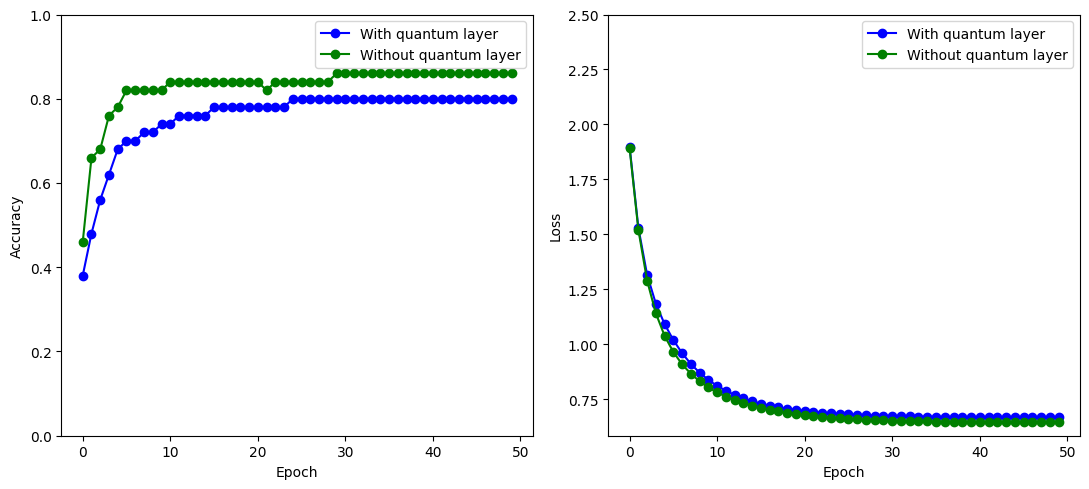

In [68]:
# plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()

plt.tight_layout()
plt.savefig('accuracy_loss.png', dpi=200, facecolor='w')
plt.show()